# Importing the Libraries

In [176]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score, recall_score, precision_score, f1_score
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE, mutual_info_classif as MIC

# Importing the dataset

In [177]:
dataset = pd.read_csv('bank-additional-full.csv', sep=';', quotechar='"')

In [178]:
dataset_copy = dataset.copy()

In [179]:
dataset.shape

(41188, 21)

#### Reordering the columns order as numerical to categorical

In [180]:
def change_column_type_object_to_categorical(df):
    object_columns = df.select_dtypes(include=['object']).columns.tolist()
    for column in object_columns:
        df[column] = pd.Categorical(df[column])

In [181]:
change_column_type_object_to_categorical(dataset_copy)

In [182]:
# Separate numerical and categorical columns
numerical_columns = dataset_copy.select_dtypes(include='number').columns.tolist()
categorical_columns = dataset_copy.select_dtypes(exclude='number').columns.tolist()

# Reorder the dataset as starting with numerical columns then categorical
new_order = numerical_columns + categorical_columns
dataset_copy = dataset_copy[new_order]

In [183]:
dataset_copy.dtypes

age                  int64
duration             int64
campaign             int64
pdays                int64
previous             int64
emp.var.rate       float64
cons.price.idx     float64
cons.conf.idx      float64
euribor3m          float64
nr.employed        float64
job               category
marital           category
education         category
default           category
housing           category
loan              category
contact           category
month             category
day_of_week       category
poutcome          category
y                 category
dtype: object

## Defining required functions:

In [184]:
def visualize_features(df,column_name):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=column_name, kde=True, color='skyblue')
    plt.title(f"Distribution of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [185]:
def visualize_target_feature(df,column_name):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=column_name, hue='y', multiple='stack', palette='Set2')
    plt.title(f"Distribution of 'y' within {column_name} Groups")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [186]:
def visualize_outliers(df, column_name):
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x=column_name, color='skyblue')
    plt.title(f"Boxplot of {column_name} (with Outliers)")
    plt.xlabel(column_name)
    plt.tight_layout()
    plt.show()

In [187]:
def visualize(df,column_name):
    visualize_features(df,column_name)
    visualize_target_feature(df,column_name)
    visualize_outliers(df, column_name)

In [188]:
def remove_outliers_by_quantiles(df, column_name, lower_quantile=0.05, upper_quantile=0.95):
    lower_bound = df[column_name].quantile(lower_quantile)
    upper_bound = df[column_name].quantile(upper_quantile)
    df.drop(df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)].index, inplace=True)

In [189]:
def extract_feature_by_thresholds(df,col_name,thresholds):
    labels = []
    for i in range(len(thresholds) - 1):
        label = f"{col_name}_({thresholds[i]}_{thresholds[i+1]}]"
        mask = (df[col_name] > thresholds[i]) & (df[col_name] <= thresholds[i+1])
        df.loc[mask, f'{col_name}_group'] = label
        labels.append(label)

In [190]:
def print_extract_feature_by_thresholds(df,col_name,thresholds):
    percentages = {}
    total_samples = len(df)
    for i in range(len(thresholds) - 1):
        lower_bound = thresholds[i]
        upper_bound = thresholds[i + 1]
        mask = (df[col_name] > lower_bound) & (df[col_name] <= upper_bound)
        count = df.loc[mask].shape[0]
        percentage = (count / total_samples)
        rounded_percentage = round(percentage, 4)
        print(f"({lower_bound}_{upper_bound}] = {rounded_percentage}, samples:{count}")

In [191]:
def calculate_success_rate(df, feature_column, target_column, lower_bound,upper_bound):
    # Filter the DataFrame for the specific condition
    filtered_df = df[(df[feature_column] >= lower_bound) & (df[feature_column] <= upper_bound)].copy()
    # Group by the feature column and calculate the rate of 'yes' for each unique value
    grouped = filtered_df.groupby(feature_column)[target_column].apply(lambda x: (x == 'yes').mean())
    success_rate = grouped.mean()
    return grouped, success_rate

In [192]:
def generate_start_end_threshold(df, col_name, increment_range):
    start = df[col_name].min() - (df[col_name].min())%increment_range
    end = df[col_name].max() - (df[col_name].max())%increment_range + increment_range
    return start, end

In [193]:
def generate_threshold(df,col_name,increment_range):
    start, end = generate_start_end_threshold(df,col_name,increment_range)
    thresholds = []
    threshold = start
    while threshold <= end:
        thresholds.append(threshold)
        threshold += increment_range
    return thresholds

In [194]:
def correlation_heatmap(df,numerical_col):
    ## taking from https://github.com/bowcai/bank-analysis/blob/main/bank-analysis.ipynb
    fig= plt.figure(figsize=(8,8))

    corr = df[numerical_col].corr()
    mask = np.triu(df[numerical_col].corr())

    axes = fig.add_axes([0, 0, 1, 1])
    sns.heatmap(corr, annot=True, mask=mask, square=True,fmt='.2g',vmin=-1, vmax=1, center= 0, cmap='viridis',
                linecolor='white', cbar_kws= {'orientation': 'vertical'}, ax=axes)

# Data Visualization

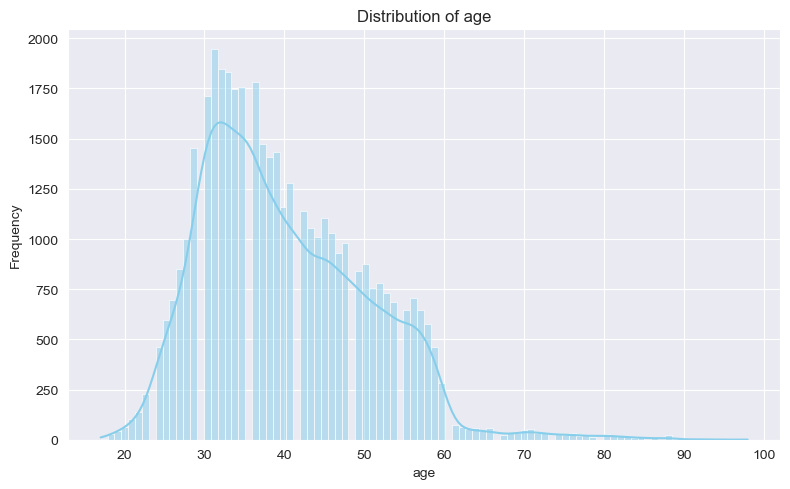

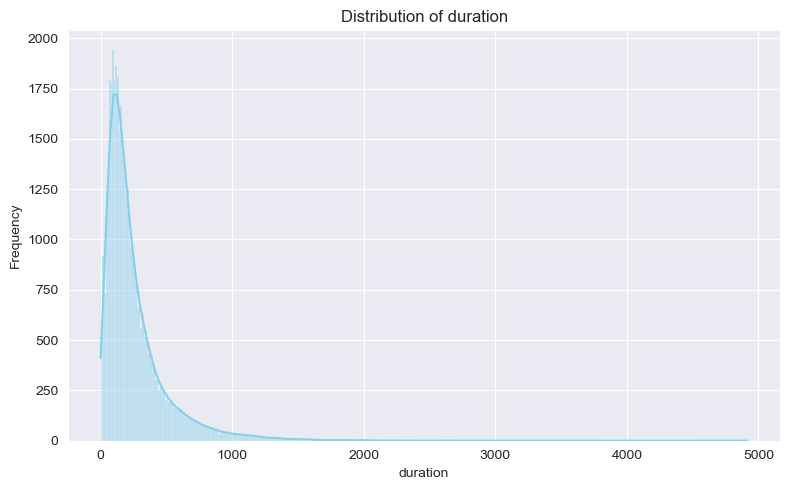

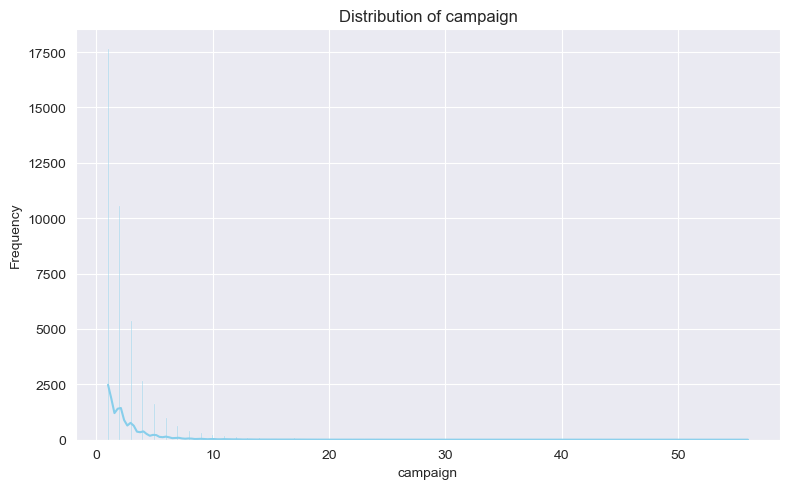

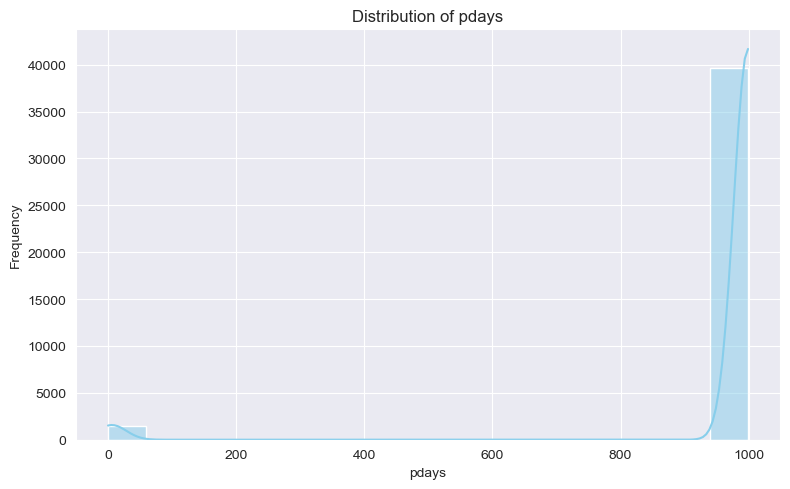

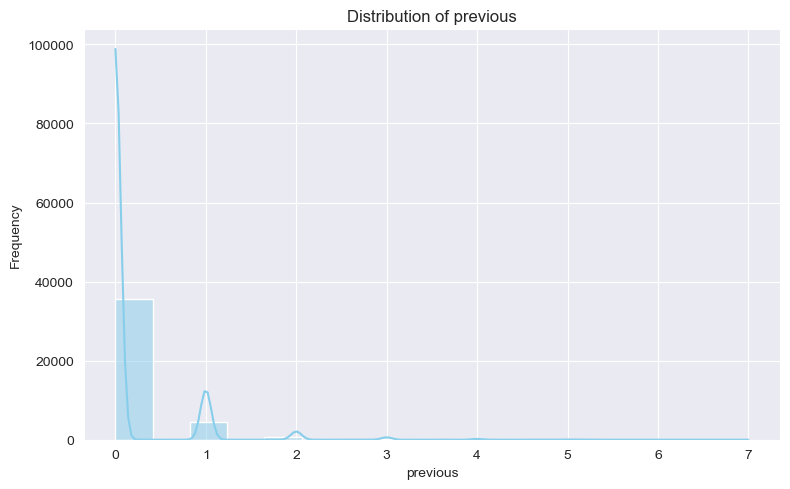

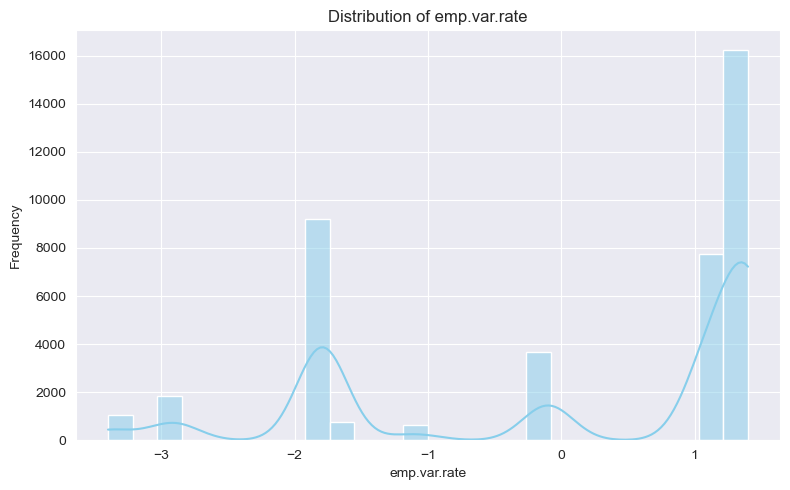

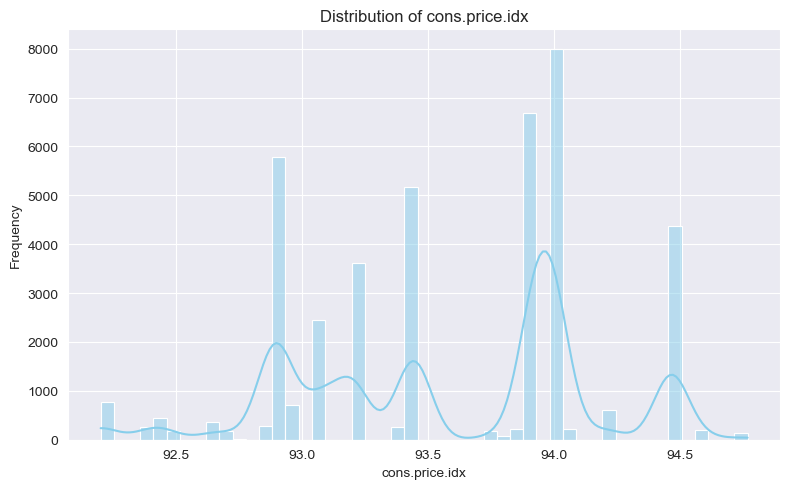

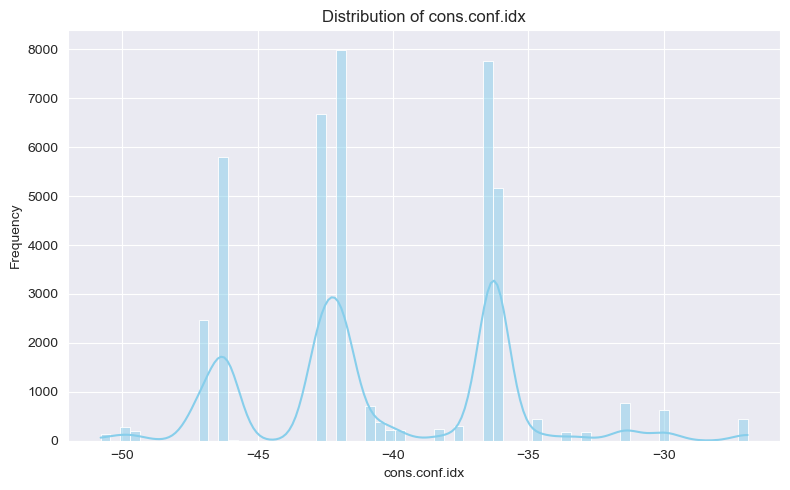

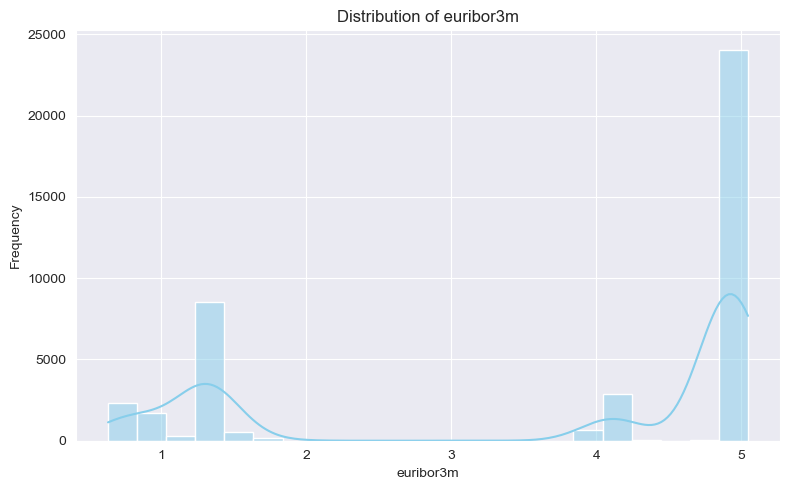

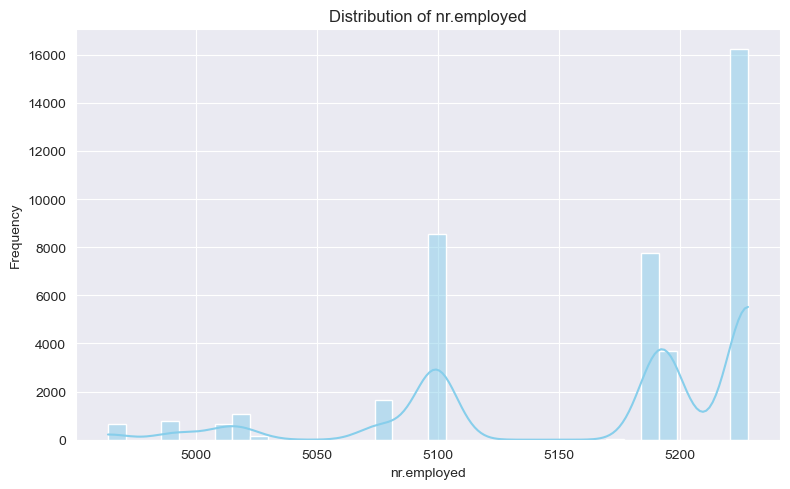

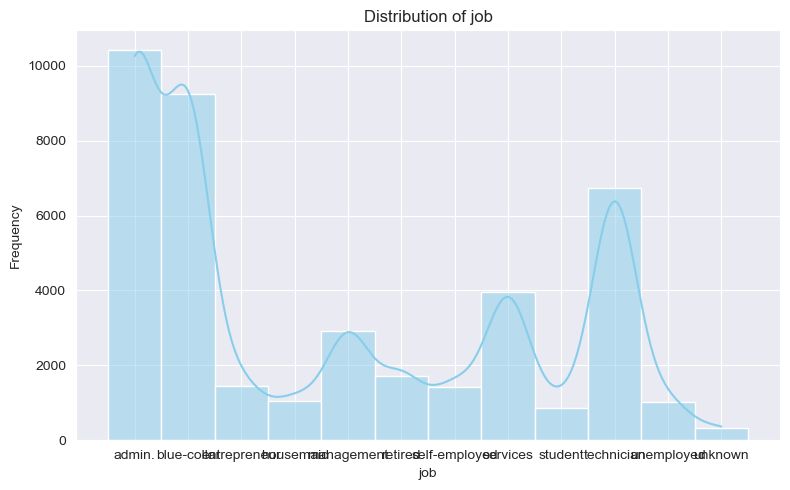

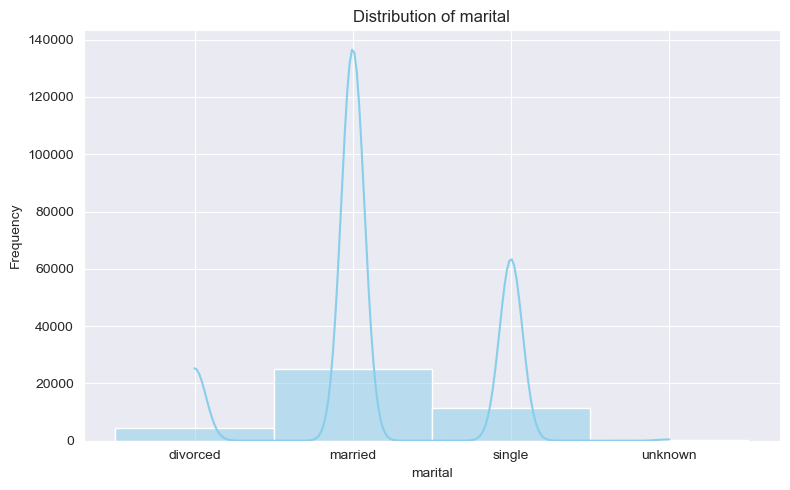

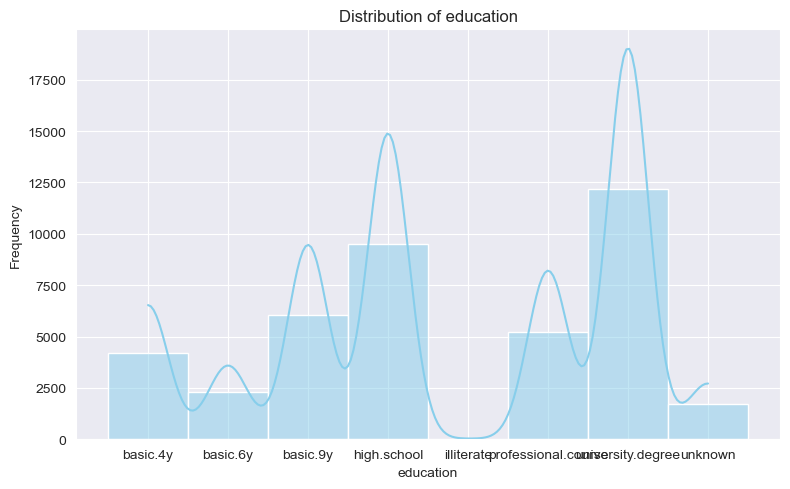

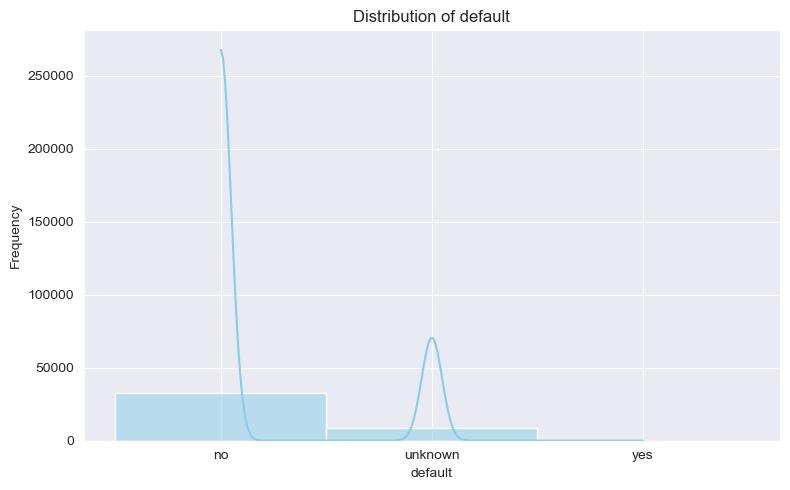

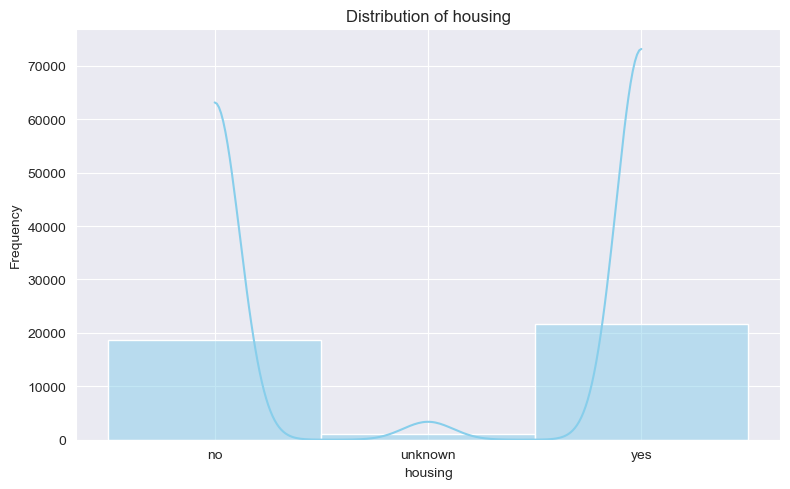

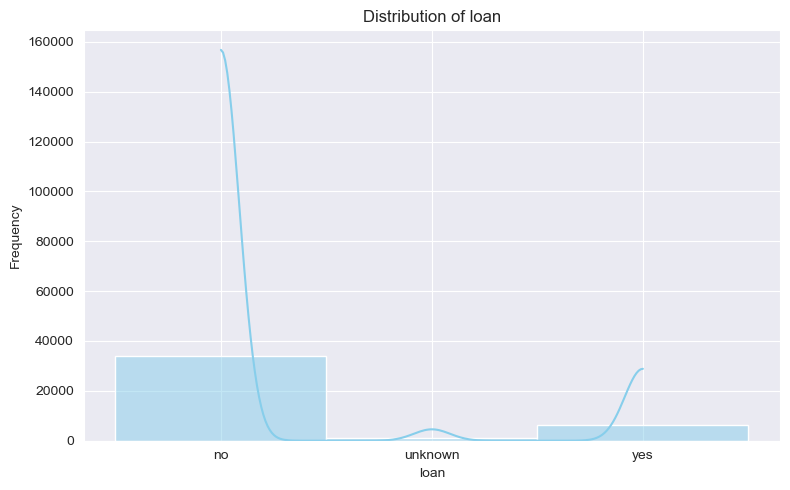

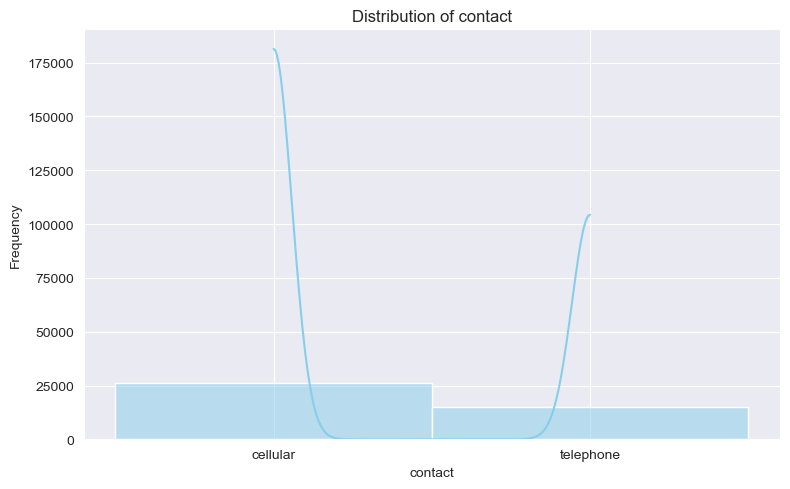

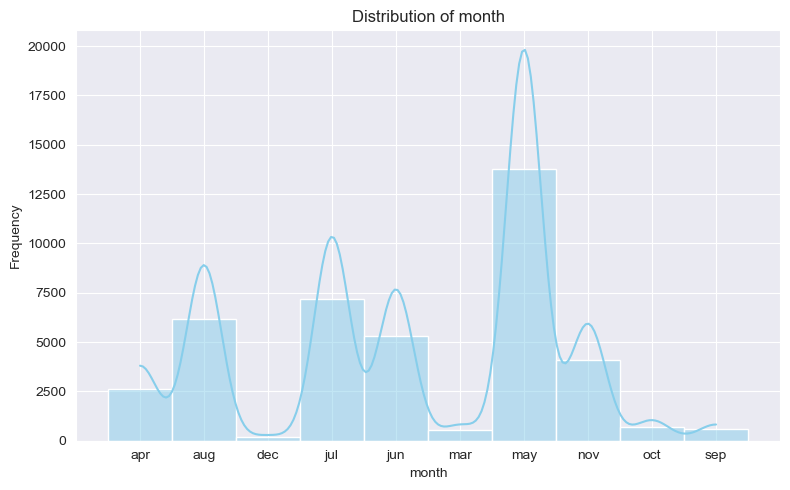

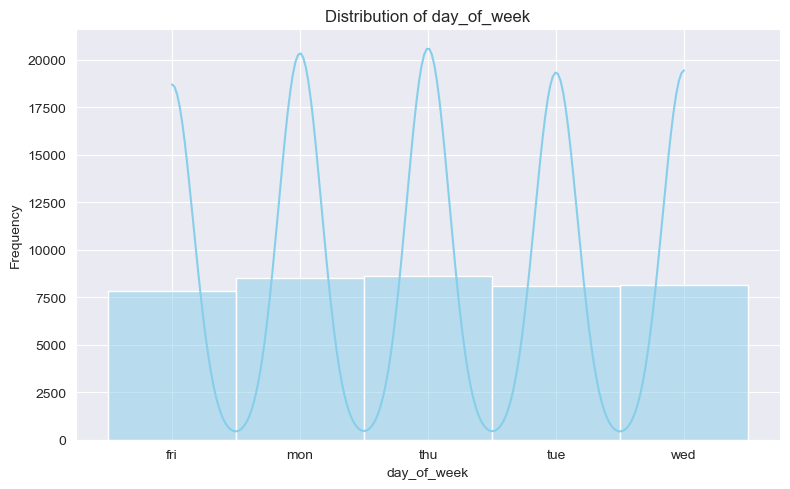

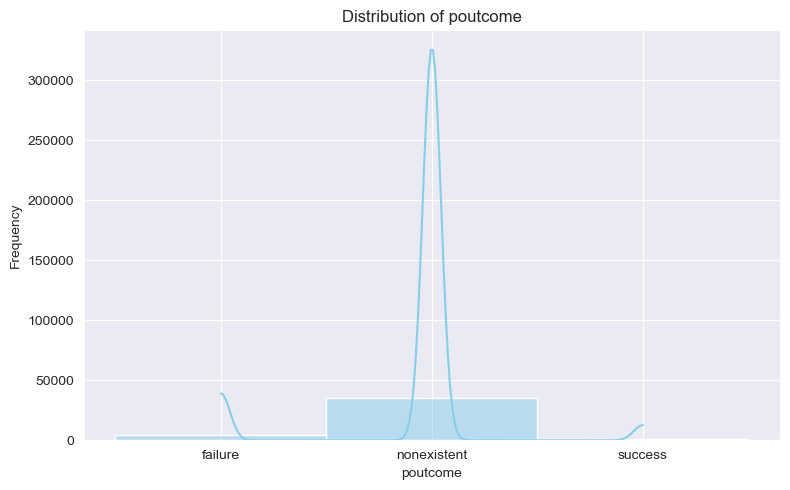

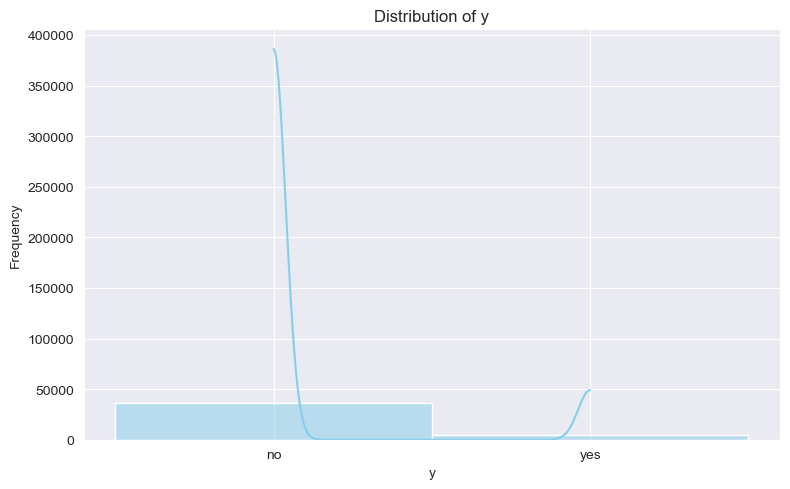

In [195]:
for col in dataset_copy.columns:
    visualize_features(dataset_copy,col)

# Handling outliers

In [196]:
numerical_columns

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [197]:
for col_name in numerical_columns:
    remove_outliers_by_quantiles(dataset_copy,col_name)

# Handling missing values

In [198]:
# Only categorical features has missing values
print(dataset_copy[categorical_columns].isin(['unknown']).sum())

job             188
marital          46
education       997
default        6314
housing         620
loan            620
contact           0
month             0
day_of_week       0
poutcome          0
y                 0
dtype: int64


In [199]:
# Replacing the "unknown" with np.nan
dataset_copy.replace('unknown', np.nan, inplace=True)
dataset_copy.fillna(dataset_copy.mode().iloc[0], inplace=True)

# Feature Extraction:

##### 1-) "Age"

In [200]:
age_threshold = generate_threshold(dataset_copy,'age',5)
print(age_threshold)

[25, 30, 35, 40, 45, 50, 55, 60]


In [201]:
print_extract_feature_by_thresholds(dataset_copy,'age',age_threshold)

(25_30] = 0.1418, samples:3772
(30_35] = 0.2413, samples:6419
(35_40] = 0.197, samples:5240
(40_45] = 0.1514, samples:4029
(45_50] = 0.1245, samples:3312
(50_55] = 0.0947, samples:2520
(55_60] = 0.0493, samples:1312


In [202]:
extract_feature_by_thresholds(dataset_copy,'age',age_threshold)

##### 2-) "duration"

In [203]:
duration_threshold = generate_threshold(dataset_copy,'duration',100)
print(duration_threshold)

[0, 100, 200, 300, 400, 500, 600, 700, 800]


In [204]:
print_extract_feature_by_thresholds(dataset_copy,'duration',duration_threshold)

(0_100] = 0.2214, samples:5890
(100_200] = 0.3457, samples:9197
(200_300] = 0.1925, samples:5122
(300_400] = 0.1074, samples:2856
(400_500] = 0.0575, samples:1529
(500_600] = 0.0381, samples:1013
(600_700] = 0.0269, samples:716
(700_800] = 0.0106, samples:281


In [205]:
extract_feature_by_thresholds(dataset_copy,'duration',duration_threshold)

##### 3-) "pdays"

In [206]:
dataset_copy['pdays_group'] = dataset_copy['pdays']
dataset_copy.loc[dataset_copy['pdays'] <= 100, 'pdays_group'] = 0
dataset_copy.loc[dataset_copy['pdays'] > 100, 'pdays_group'] = 1

In [207]:
print(dataset_copy['pdays_group'].value_counts())

pdays_group
1    26604
Name: count, dtype: int64


##### 4-) "emp.var.rate"

In [208]:
dataset_copy['emp.var.rate_sign'] = dataset_copy['emp.var.rate']
dataset_copy.loc[dataset_copy['emp.var.rate'] < 0, 'emp.var.rate_sign'] = -1    # negative employment variation rate
dataset_copy.loc[dataset_copy['emp.var.rate'] > 0, 'emp.var.rate_sign'] = 1     # positive employment variation rate

In [209]:
print(dataset_copy['emp.var.rate_sign'].value_counts())

emp.var.rate_sign
 1.0    17789
-1.0     8815
Name: count, dtype: int64


##### 5-) "cons.conf.idx"

In [210]:
cons_conf_idx_threshold = generate_threshold(dataset_copy,'cons.conf.idx',5)
print(cons_conf_idx_threshold)

[-50.0, -45.0, -40.0, -35.0]


In [211]:
print_extract_feature_by_thresholds(dataset_copy,'cons.conf.idx',cons_conf_idx_threshold)

(-50.0_-45.0] = 0.2094, samples:5571
(-45.0_-40.0] = 0.4134, samples:10997
(-40.0_-35.0] = 0.3772, samples:10036


In [212]:
extract_feature_by_thresholds(dataset_copy,'cons.conf.idx',cons_conf_idx_threshold)

# Encoding features:

In [213]:
print(categorical_columns)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


In [214]:
label_encoded_features = ['age_group','duration_group','cons.conf.idx_group',
                          'education','default','housing','loan','month',
                          'day_of_week','poutcome','marital','contact','y']
onehot_encoded_features = ['job']

In [215]:
ohe = OneHotEncoder(dtype='int32')
label_encoder = LabelEncoder()

for col in onehot_encoded_features:
    transformed = ohe.fit_transform(dataset_copy[[col]])
    dataset_copy[ohe.categories_[0]] = transformed.toarray()

for column in label_encoded_features:
    dataset_copy[column] = label_encoder.fit_transform(dataset_copy[column])

In [216]:
dataset_copy.dtypes

age                       int64
duration                  int64
campaign                  int64
pdays                     int64
previous                  int64
emp.var.rate            float64
cons.price.idx          float64
cons.conf.idx           float64
euribor3m               float64
nr.employed             float64
job                    category
marital                   int32
education                 int32
default                   int32
housing                   int32
loan                      int32
contact                   int32
month                     int32
day_of_week               int32
poutcome                  int32
y                         int32
age_group                 int32
duration_group            int32
pdays_group               int64
emp.var.rate_sign       float64
cons.conf.idx_group       int32
admin.                    int32
blue-collar               int32
entrepreneur              int32
housemaid                 int32
management                int32
retired 

# Feature Reduction:

<Axes: >

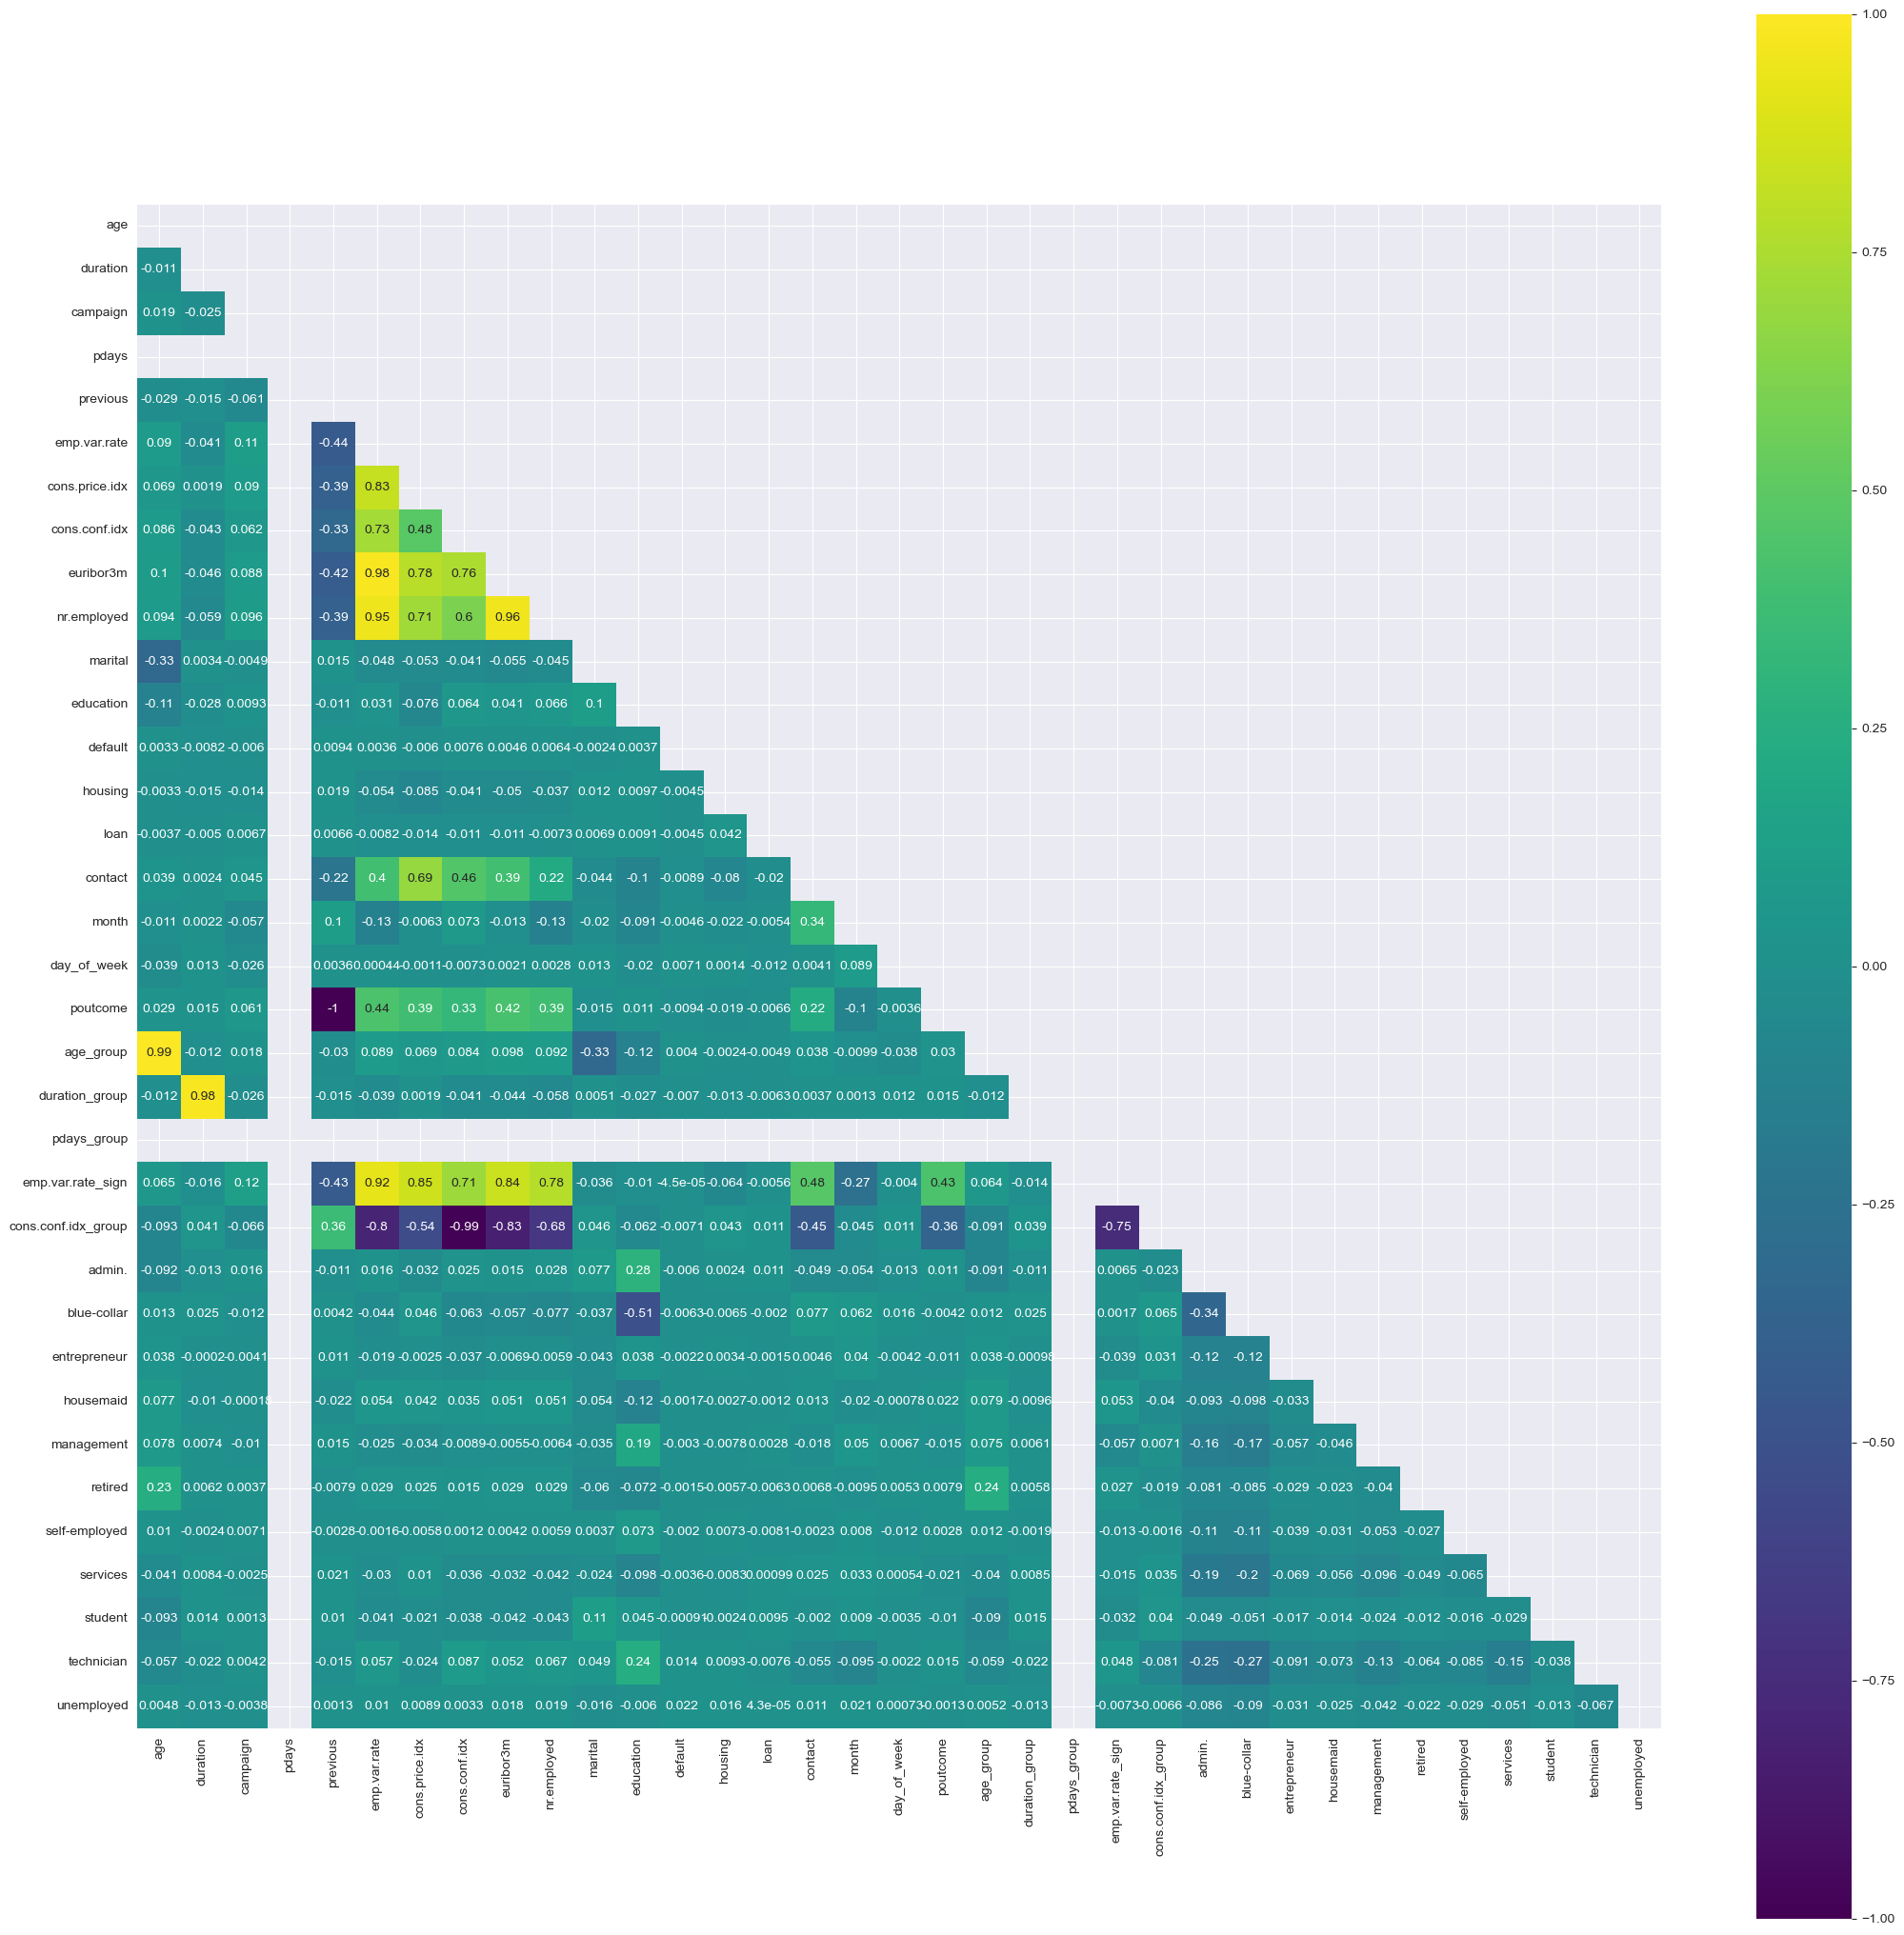

In [217]:
fig= plt.figure(figsize=(20,20))
df = dataset_copy.drop(['y','job'], axis=1)
corr = df.corr()
mask = np.triu(df.corr())

axes = fig.add_axes([0, 0, 1, 1])
sns.heatmap(corr, annot=True, mask=mask, square=True,fmt='.2g',vmin=-1, vmax=1, center= 0, cmap='viridis',
            linecolor='white', cbar_kws= {'orientation': 'vertical'}, ax=axes)

In [218]:
# Remove the one of the high correlated features
dataset_selected= dataset_copy.drop(['age','duration','pdays','cons.price.idx','job','poutcome','emp.var.rate','cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)
numerical_columns = dataset_selected.select_dtypes(include='number').columns.tolist()

<Axes: >

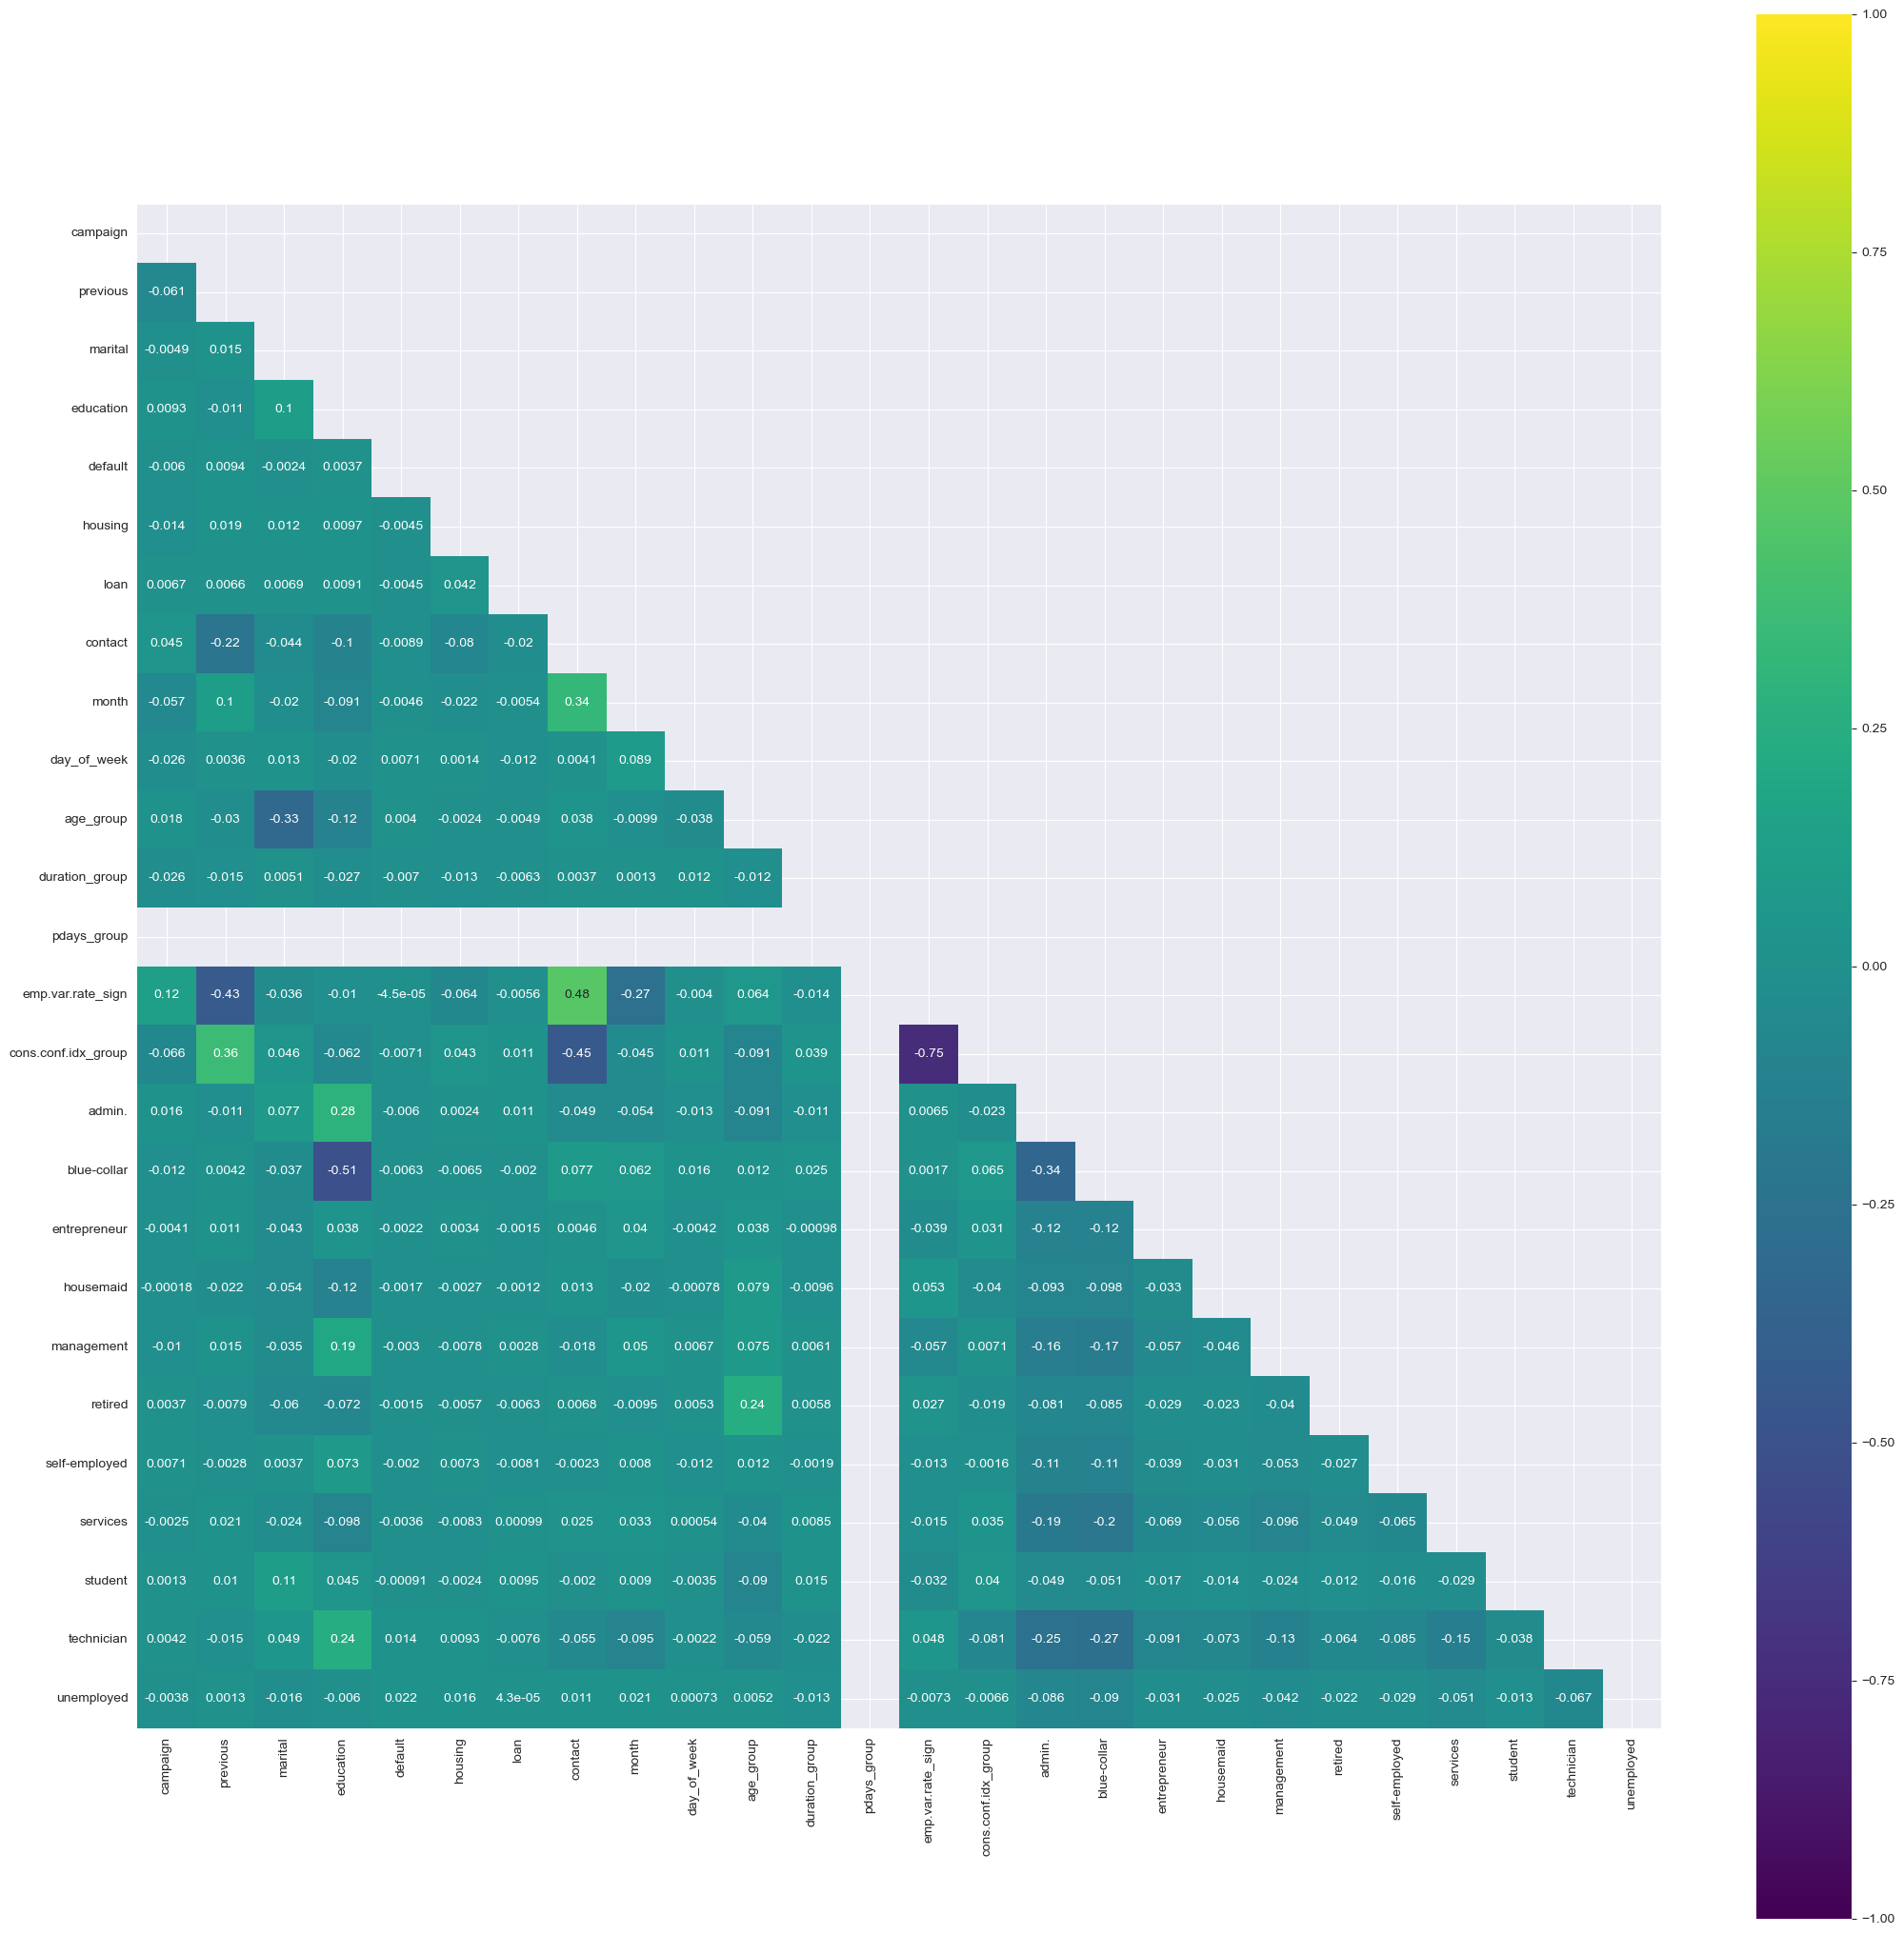

In [219]:
fig= plt.figure(figsize=(20,20))
df = dataset_selected.drop(['y'], axis=1)
corr = df.corr()
mask = np.triu(df.corr())

axes = fig.add_axes([0, 0, 1, 1])
sns.heatmap(corr, annot=True, mask=mask, square=True,fmt='.2g',vmin=-1, vmax=1, center= 0, cmap='viridis',
            linecolor='white', cbar_kws= {'orientation': 'vertical'}, ax=axes)

In [220]:
dataset_selected.columns

Index(['campaign', 'previous', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'y', 'age_group',
       'duration_group', 'pdays_group', 'emp.var.rate_sign',
       'cons.conf.idx_group', 'admin.', 'blue-collar', 'entrepreneur',
       'housemaid', 'management', 'retired', 'self-employed', 'services',
       'student', 'technician', 'unemployed'],
      dtype='object')

In [221]:
dataset_selected.dtypes

campaign                 int64
previous                 int64
marital                  int32
education                int32
default                  int32
housing                  int32
loan                     int32
contact                  int32
month                    int32
day_of_week              int32
y                        int32
age_group                int32
duration_group           int32
pdays_group              int64
emp.var.rate_sign      float64
cons.conf.idx_group      int32
admin.                   int32
blue-collar              int32
entrepreneur             int32
housemaid                int32
management               int32
retired                  int32
self-employed            int32
services                 int32
student                  int32
technician               int32
unemployed               int32
dtype: object

# Feature Sampling:

In [222]:
dataset_copy.shape

(26604, 37)

In [223]:
X = dataset_selected.drop(['y'], axis=1)
y = dataset_selected['y']

In [224]:
X.head()

,campaign,previous,marital,education,default,housing,loan,contact,month,day_of_week,...,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
0,1,0,1,0,0,0,0,1,4,1,...,0,0,1,0,0,0,0,0,0,0
1,1,0,1,3,0,0,0,1,4,1,...,0,0,0,0,0,0,1,0,0,0
2,1,0,1,3,0,1,0,1,4,1,...,0,0,0,0,0,0,1,0,0,0
3,1,0,1,1,0,0,0,1,4,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,3,0,0,1,1,4,1,...,0,0,0,0,0,0,1,0,0,0


In [225]:
counter = Counter(y)
print(f"Before oversampling:{counter}")

oversampling = SMOTE()
X_oversampled, y_smote_sampler = oversampling.fit_resample(X, y)

counter = Counter(y_smote_sampler)
print(f"After oversampling:{counter}")

Before oversampling:Counter({0: 25653, 1: 951})
After oversampling:Counter({0: 25653, 1: 25653})


# Feature Transformation

In [226]:
# Apply Min_Max scaler
scaler_minmax = MinMaxScaler()
scaler_standard = StandardScaler()

X_minmax = scaler_minmax.fit_transform(X_oversampled)
X_standard = scaler_standard.fit_transform(X_oversampled)

# Feature Selection:

In [227]:
# Prepare dataset for RFE (Recursive Feature Elimination)
def func_RFE_X_rfe(param_X,param_y):
    model = LogisticRegression(max_iter=1000)
    rfe = RFE(model, step = 4)
    fit = rfe.fit(param_X,param_y)
    selected_features = fit.support_
    X_rfe = param_X[:, selected_features]
    print("Num Features: %s" % (fit.n_features_))
    print("Selected Features: %s" % (fit.support_))
    print("Feature Ranking: %s" % (fit.ranking_))
    return X_rfe

In [228]:
# Prepare dataset for SelectKBest (score_func=chi2)
def func_SelectKBest_X_chi2(param_X,param_y):
    test = SelectKBest(score_func=chi2, k=23)
    fit = test.fit(param_X,param_y)
    X_chi2 = fit.transform(param_X)
    return X_chi2

In [229]:
# Prepare dataset for Ridge
def func_Ridge_X_ridge(param_X,param_y):
    ridge = Ridge(alpha=1.0)
    ridge.fit(param_X,param_y)
    best_alpha = ridge.alpha
    ridge_model = Ridge(alpha=best_alpha)
    ridge_model.fit(param_X,param_y)
    selector = SelectFromModel(ridge_model)
    X_ridge = selector.transform(param_X)
    return X_ridge

In [230]:
# Prepare dataset for MIC (mutual_info_classification)
def func_MIC_X_mic(param_X,param_y):
    mi_scores = MIC(param_X,param_y)
    mi_score_selected_index = np.where(mi_scores <0.2)[0]
    X_mic = param_X[:,mi_score_selected_index]
    return X_mic

In [231]:
def print_scores(accuracy_score, recall_score, precision_score, f1_score, model_name):
    print(f"accuracy_{model_name}:{accuracy_score:10.4f}\t"
          f"recall {model_name}:{recall_score:10.4f}\t"
          f"precision {model_name}:{precision_score:10.4f}\t"
          f"f1_score_{model_name}:{f1_score:10.4f}")

In [232]:
def predict_scores(model, x_test, y_test):
    score           = model.score(x_test,y_test)
    y_predict       = model.predict(x_test)
    score_recall    = recall_score(y_test,y_predict)
    score_precision = precision_score(y_test,y_predict)
    f1_scr          = f1_score(y_test, y_predict)
    return score,score_recall,score_precision, f1_scr

In [233]:
def func_Calculate_Model_Scores(param_x,param_y, X_chi2, X_rfe, X_ridge, X_mic):
    # Split the data into training and testing sets
    
    X_train, X_test, y_train, y_test                     = train_test_split(param_x,param_y, random_state=0, stratify=param_y)
    X_train_chi2, X_test_chi2, y_train_chi2, y_test_chi2 = train_test_split(X_chi2, param_y, random_state=0, stratify=param_y)
    X_train_RFE, X_test_RFE, y_train_RFE, y_test_RFE     = train_test_split(X_rfe, param_y, random_state=0, stratify=param_y)
    X_train_Ridge, X_test_Ridge, y_train_Ridge, y_test_Ridge = train_test_split(X_ridge, param_y, random_state=0, stratify=param_y)
    X_train_MIC, X_test_MIC, y_train_MIC, y_test_MIC     = train_test_split(X_mic, param_y, random_state=0, stratify=param_y)
    RFC = RandomForestClassifier()

    # Compare results with Random Forest Classifier
    model_default = RFC.fit(X_train,y_train)
    score_default, recall_score_default, precision_score_default, f1_score_default = predict_scores(model_default,X_test,y_test) 

    model_MIC = RFC.fit(X_train_MIC,y_train_MIC)
    score_MIC, recall_score_MIC, precision_score_MIC, f1_score_MIC = predict_scores(model_MIC,X_test_MIC,y_test_MIC)

    model_chi2 = RFC.fit(X_train_chi2,y_train_chi2)
    score_chi2, recall_score_chi2, precision_score_chi2, f1_score_chi2 = predict_scores(model_chi2,X_test_chi2,y_test_chi2)

    model_RFE = RFC.fit(X_train_RFE,y_train_RFE)
    score_rfe, recall_score_rfe, precision_score_rfe, f1_score_rfe = predict_scores(model_RFE,X_test_RFE,y_test_RFE)

    model_Ridge = RFC.fit(X_train_Ridge,y_train_Ridge)
    score_ridge, recall_score_ridge, precision_score_ridge, f1_score_ridge = predict_scores(model_Ridge,X_test_Ridge,y_test_Ridge)

    #---------------------------------------------------------------------------------
    print_scores(score_MIC, recall_score_MIC, precision_score_MIC, f1_score_MIC, "MIC")
    print_scores(score_rfe, recall_score_rfe, precision_score_rfe, f1_score_rfe, "RFE")
    print_scores(score_chi2, recall_score_chi2, precision_score_chi2, f1_score_chi2, "chi2")
    print_scores(score_ridge, recall_score_ridge, precision_score_ridge, f1_score_ridge, "Ridge")
    print_scores(score_default, recall_score_default, precision_score_default, f1_score_default, "default")

In [234]:
print("Scores for minmax scaler:")
x_chi2 = func_SelectKBest_X_chi2(X_minmax,y_smote_sampler)
x_rfe = func_Ridge_X_ridge(X_minmax,y_smote_sampler)
x_ridge = func_Ridge_X_ridge(X_minmax,y_smote_sampler)
x_mic = func_MIC_X_mic(X_minmax,y_smote_sampler)

func_Calculate_Model_Scores(X_minmax, y_smote_sampler, x_chi2, x_rfe, x_ridge, x_mic)

Scores for minmax scaler:
accuracy_MIC:    0.9611	recall MIC:    0.9729	precision MIC:    0.9505	f1_score_MIC:    0.9615
accuracy_RFE:    0.9110	recall RFE:    0.9228	precision RFE:    0.9014	f1_score_RFE:    0.9120
accuracy_chi2:    0.9754	recall chi2:    0.9871	precision chi2:    0.9645	f1_score_chi2:    0.9756
accuracy_Ridge:    0.9107	recall Ridge:    0.9202	precision Ridge:    0.9030	f1_score_Ridge:    0.9115
accuracy_default:    0.9780	recall default:    0.9875	precision default:    0.9691	f1_score_default:    0.9782


# Splitting the dataset into the Training set and Test set

In [235]:
X_train, X_test, y_train, y_test   = train_test_split(X_oversampled,y_smote_sampler, random_state=42)

# Feature Scaling

In [236]:
sc = StandardScaler()
X_train_ml = sc.fit_transform(X_train)
X_test_ml = sc.transform(X_test)

# ML Algorithms Implementation:

In [237]:
def plot_confusion_matrix(X_test, y_test, model, model_name):
    # Generate confusion matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    # Create a custom colormap for better readability
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Create a heatmap with customized colors and annotations
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap=cmap, fmt='g', cbar=False)

    # Set labels, title, and layout
    plt.title(f'Confusion Matrix of {model_name}', fontsize=16)
    plt.xlabel('Predicted', fontsize=8)
    plt.ylabel('Actual', fontsize=8)
    plt.xticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
    plt.yticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
    plt.tight_layout()

    plt.show()

In [238]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def draw_AUC_graph(train_X, test_X, train_y, test_y, model, model_name):
    # Get predicted probabilities for the positive class for both train and test sets
    y_train_probs = model.predict_proba(train_X)[:, 1]
    y_test_probs = model.predict_proba(test_X)[:, 1]

    # Compute ROC curve and ROC AUC for both train and test sets
    fpr_train, tpr_train, _ = roc_curve(train_y, y_train_probs)
    fpr_test, tpr_test, _ = roc_curve(test_y, y_test_probs)

    roc_auc_train = roc_auc_score(train_y, y_train_probs)
    roc_auc_test = roc_auc_score(test_y, y_test_probs)

    # Plot ROC curves for both train and test sets, display AUC values as labels
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f'Train ROC Curve (AUC = {roc_auc_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC Curve (AUC = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {model_name}')
    plt.legend()
    plt.show()

    print(f"Train AUC: {roc_auc_train:.4f}")
    print(f"Test AUC: {roc_auc_test:.4f}")

# Training the Classification models on the Training set

In [239]:
def ml_algorithms_without_hyper_tuning(X_train,y_train):

    # Initialize individual classifiers
    dtc = DecisionTreeClassifier()
    knn = KNeighborsClassifier()
    svc = SVC(probability=True)
    logistic = LogisticRegression(max_iter=1000)
    rfc = RandomForestClassifier()
    svm = SVC(probability=True)
    gb = GradientBoostingClassifier()

    # Fit individual classifiers
    dtc.fit(X_train, y_train)
    knn.fit(X_train, y_train)
    svc.fit(X_train, y_train)
    logistic.fit(X_train, y_train)
    rfc.fit(X_train, y_train)
    svm.fit(X_train, y_train)
    gb.fit(X_train, y_train)
    
    return dtc, knn, svc, logistic, rfc, svm, gb

# Ensemble Models

In [240]:
def ensemble_models(X_train,y_train,estimators):
    
    voting = VotingClassifier(estimators=estimators)
    #stacking = StackingClassifier(estimators=estimators)

    voting.fit(X_train,y_train)
    #stacking.fit(X_train,y_train)
    
    return  voting

In [241]:
model_dtc, model_knn, model_svc, model_lr, model_rfc, model_svm, model_gb= ml_algorithms_without_hyper_tuning(X_train=X_train,y_train=y_train)

In [242]:
estimators = [('dtc',model_dtc),('knn',model_knn),('svc',model_svc),('logistic',model_lr),('rfc',model_rfc),('svm',model_svm), ('gb', model_gb)]

In [247]:
model_voting = VotingClassifier(estimators=estimators, voting='soft')
model_voting.fit(X_train,y_train)

VotingClassifier(estimators=[('dtc', DecisionTreeClassifier()),
                             ('knn', KNeighborsClassifier()),
                             ('svc', SVC(probability=True)),
                             ('logistic', LogisticRegression(max_iter=1000)),
                             ('rfc', RandomForestClassifier()),
                             ('svm', SVC(probability=True)),
                             ('gb', GradientBoostingClassifier())],
                 voting='soft')

In [248]:
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [249]:
models = [model_dtc, model_knn, model_svc, model_lr, model_rfc, model_svm, model_gb, model_voting, model_xgb]
model_names = ["Decision Tree","KNN","SVC","Logistic_regression","Random Forest","SVM", "GB", "Voting", "XGB"]

# Visualizing the ROC curve with AUC values

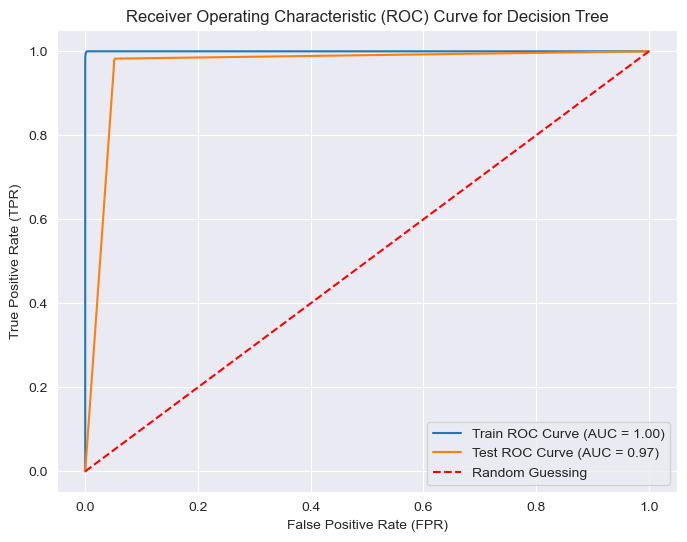

Train AUC: 1.0000
Test AUC: 0.9654


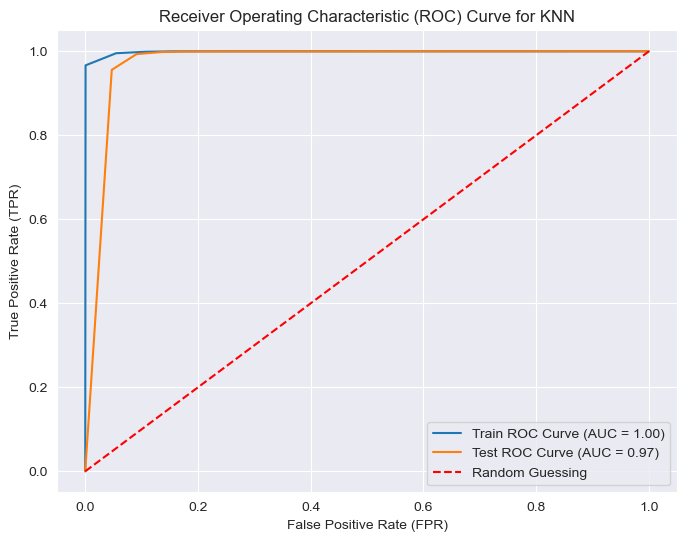

Train AUC: 0.9985
Test AUC: 0.9739


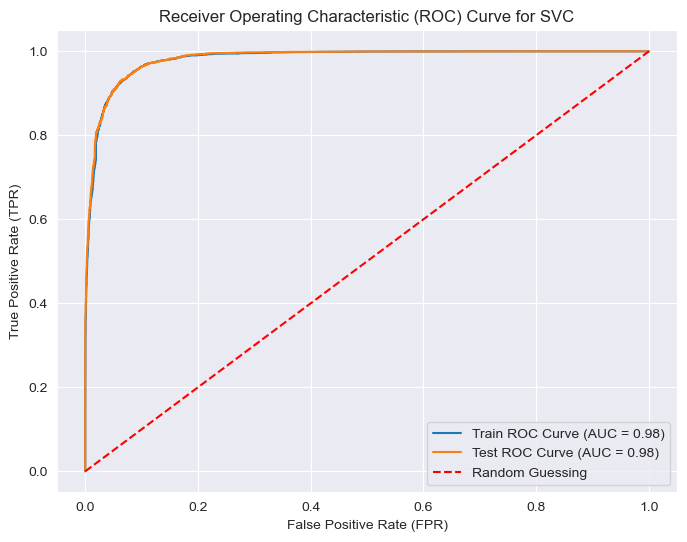

Train AUC: 0.9820
Test AUC: 0.9829


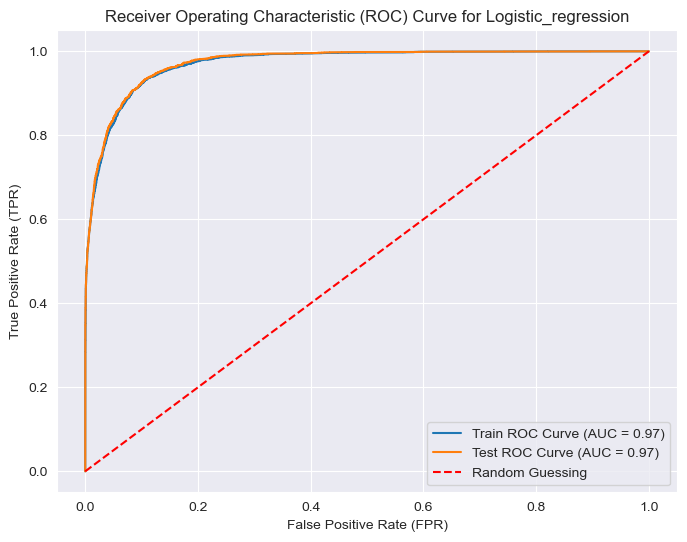

Train AUC: 0.9717
Test AUC: 0.9733


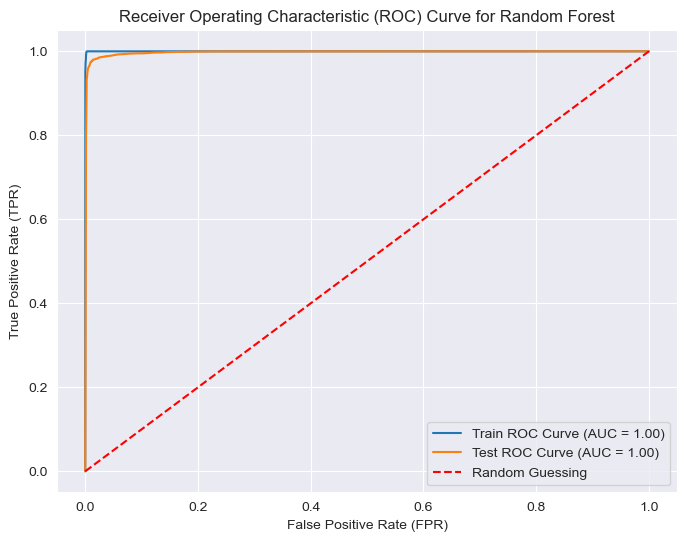

Train AUC: 1.0000
Test AUC: 0.9975


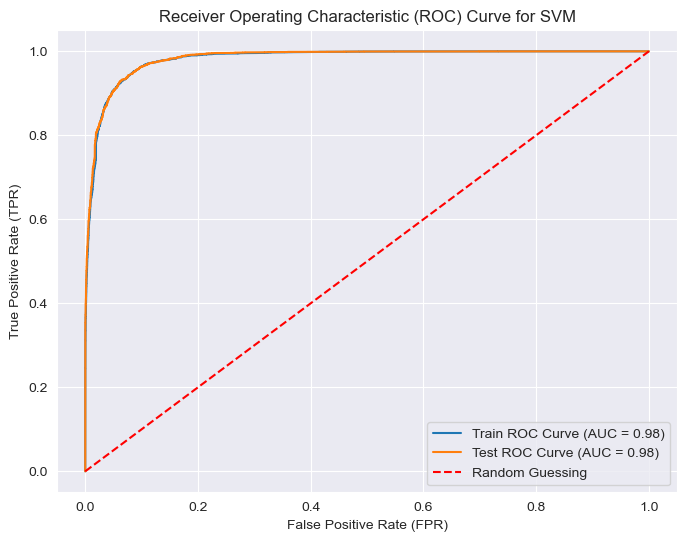

Train AUC: 0.9820
Test AUC: 0.9829


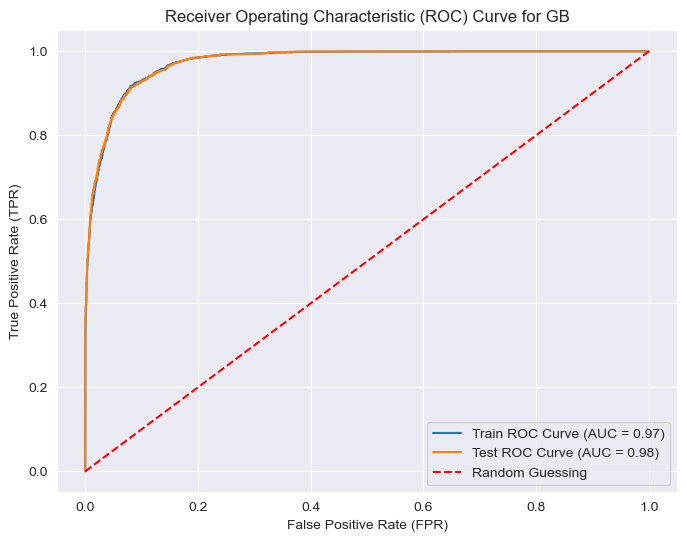

Train AUC: 0.9749
Test AUC: 0.9751


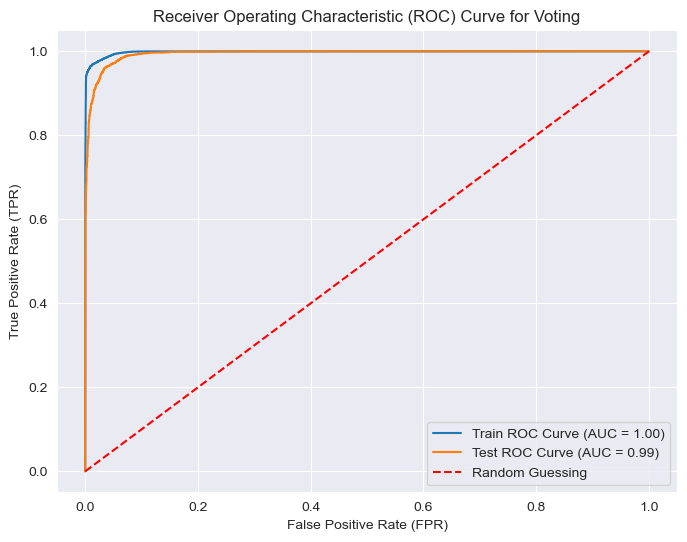

Train AUC: 0.9984
Test AUC: 0.9942


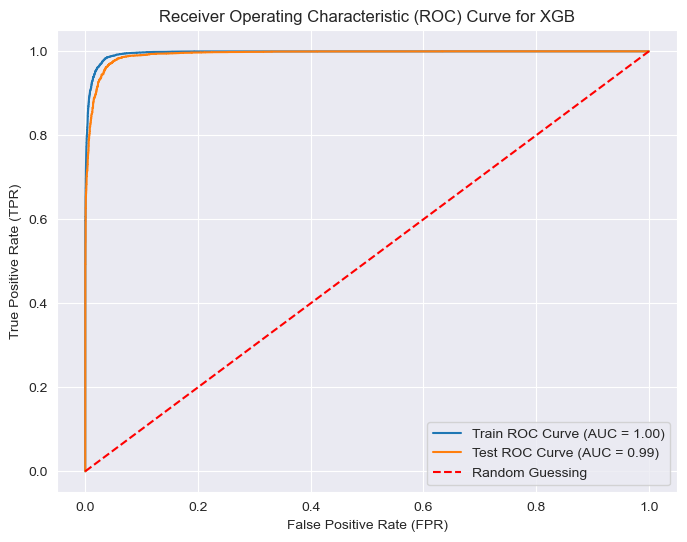

Train AUC: 0.9966
Test AUC: 0.9932


In [250]:
for model,model_name in zip(models,model_names):
    draw_AUC_graph(X_train,X_test,y_train,y_test,model,model_name)

# Visualizing the Confusion Matrix

DecisionTreeClassifier(), Decision Tree


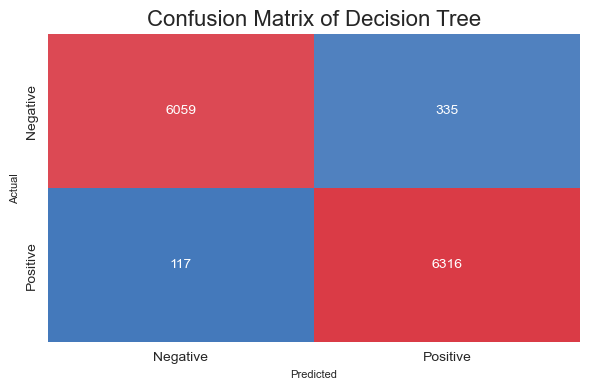

KNeighborsClassifier(), KNN


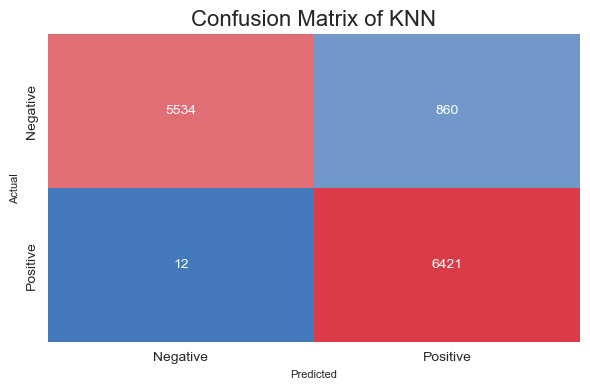

SVC(probability=True), SVC


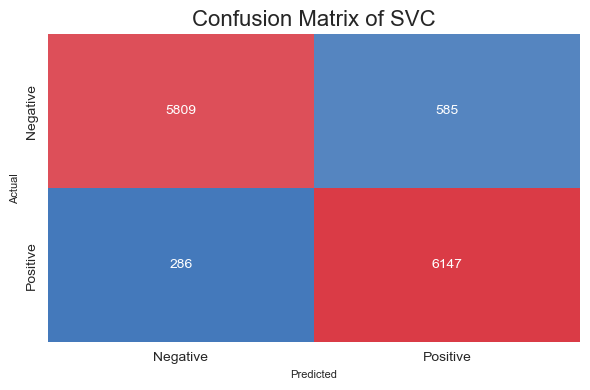

LogisticRegression(max_iter=1000), Logistic_regression


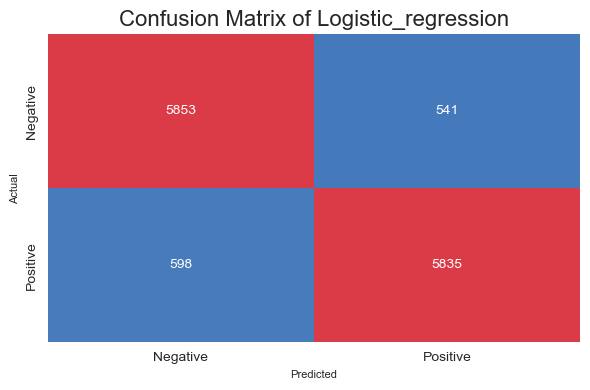

RandomForestClassifier(), Random Forest


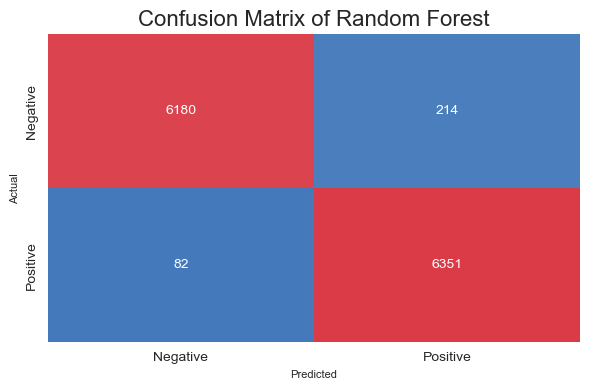

SVC(probability=True), SVM


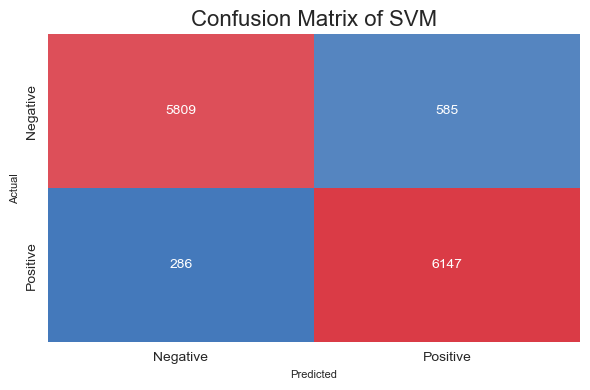

GradientBoostingClassifier(), GB


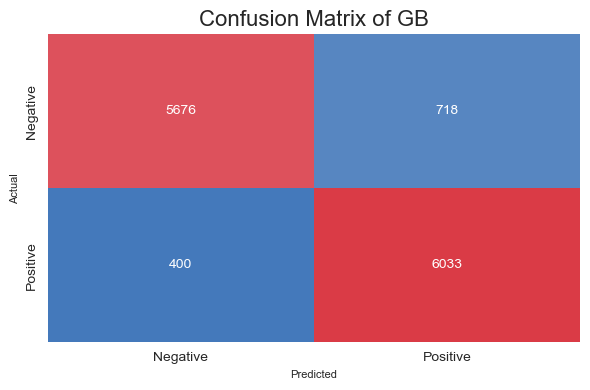

VotingClassifier(estimators=[('dtc', DecisionTreeClassifier()),
                             ('knn', KNeighborsClassifier()),
                             ('svc', SVC(probability=True)),
                             ('logistic', LogisticRegression(max_iter=1000)),
                             ('rfc', RandomForestClassifier()),
                             ('svm', SVC(probability=True)),
                             ('gb', GradientBoostingClassifier())],
                 voting='soft'), Voting


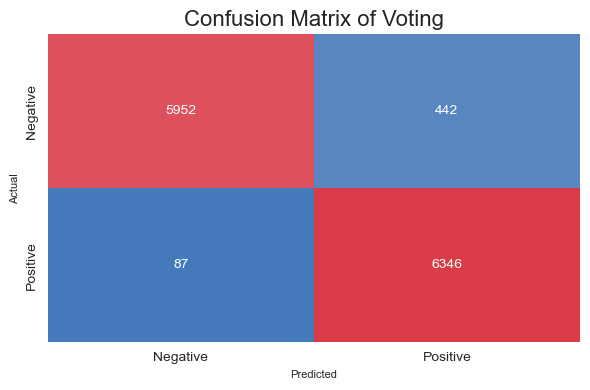

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), XGB


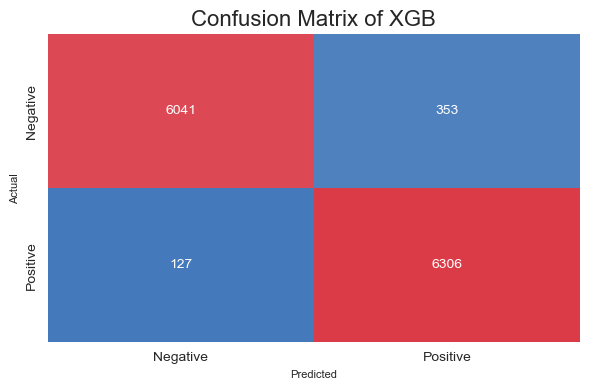

In [251]:
for model,model_name in zip(models,model_names):
    print(f"{model}, {model_name}")
    plot_confusion_matrix(X_test=X_test, y_test=y_test, model=model, model_name=model_name)

# Printing the accuracy,recall,precision,f1 scores for ml models:

In [252]:
score_dtc, recall_score_dtc, precision_score_dtc, f1_score_dtc = predict_scores(model_dtc,X_test,y_test)
score_knn, recall_score_knn, precision_score_knn, f1_score_knn = predict_scores(model_knn,X_test,y_test)
score_svc, recall_score_svc, precision_score_svc, f1_score_svc = predict_scores(model_svc,X_test,y_test)
score_lr, recall_score_lr, precision_score_lr, f1_score_lr     = predict_scores(model_lr,X_test,y_test)
score_rfc, recall_score_rfc, precision_score_rfc, f1_score_rfc = predict_scores(model_rfc,X_test,y_test)
score_svm, recall_score_svm, precision_score_svm, f1_score_svm = predict_scores(model_svm,X_test,y_test)
score_gb, recall_score_gb, precision_score_gb, f1_score_gb = predict_scores(model_gb,X_test,y_test)

In [253]:
print_scores(score_dtc, recall_score_dtc, precision_score_dtc, f1_score_dtc, "DTC")
print_scores(score_knn, recall_score_knn, precision_score_knn, f1_score_knn, "KNN")
print_scores(score_svc, recall_score_svc, precision_score_svc, f1_score_svc, "SVC")
print_scores(score_lr, recall_score_lr, precision_score_lr, f1_score_lr, "Logistic") # logistic_regression
print_scores(score_rfc, recall_score_rfc, precision_score_rfc, f1_score_rfc, "RFC")
print_scores(score_svm, recall_score_svm, precision_score_svm, f1_score_svm, "SVM")
print_scores(score_gb, recall_score_gb, precision_score_gb, f1_score_gb, "GB")

accuracy_DTC:    0.9648	recall DTC:    0.9818	precision DTC:    0.9496	f1_score_DTC:    0.9655
accuracy_KNN:    0.9320	recall KNN:    0.9981	precision KNN:    0.8819	f1_score_KNN:    0.9364
accuracy_SVC:    0.9321	recall SVC:    0.9555	precision SVC:    0.9131	f1_score_SVC:    0.9338
accuracy_Logistic:    0.9112	recall Logistic:    0.9070	precision Logistic:    0.9152	f1_score_Logistic:    0.9111
accuracy_RFC:    0.9769	recall RFC:    0.9873	precision RFC:    0.9674	f1_score_RFC:    0.9772
accuracy_SVM:    0.9321	recall SVM:    0.9555	precision SVM:    0.9131	f1_score_SVM:    0.9338
accuracy_GB:    0.9128	recall GB:    0.9378	precision GB:    0.8936	f1_score_GB:    0.9152


# Printing the accuracy,recall,precision,f1 scores for ensemble models:

In [254]:
score_voting, recall_score_voting, precision_score_voting, f1_score_voting = predict_scores(model_voting,X_test,y_test)
score_xgb, recall_score_xgb, precision_score_xgb, f1_score_xgb = predict_scores(model_xgb,X_test,y_test)

In [255]:
print_scores(score_voting, recall_score_voting, precision_score_voting, f1_score_voting, "Voting")
print_scores(score_xgb, recall_score_xgb, precision_score_xgb, f1_score_xgb, "XGB")

accuracy_Voting:    0.9588	recall Voting:    0.9865	precision Voting:    0.9349	f1_score_Voting:    0.9600
accuracy_XGB:    0.9626	recall XGB:    0.9803	precision XGB:    0.9470	f1_score_XGB:    0.9633


# Cross Validation of ML and ensemble models

In [175]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1,5,10,20],
    'random_state': [0]
}


# Create GridSearchCV
grid_search = GridSearchCV(estimator=model_rfc, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, error_score='raise')

# Perform grid search on training data
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
best_Score = grid_search.best_score_

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


In [171]:
print(best_params)
print(best_estimator)
print(best_Score)

{'criterion': 'gini'}
DecisionTreeClassifier(random_state=42)
0.956391766997772


In [172]:
best_model_rfc = RandomForestClassifier(**best_params)
best_model_rfc.fit(X_train, y_train)

score_rfc, recall_score_rfc, precision_score_rfc, f1_score_rfc = predict_scores(best_model_rfc,X_test,y_test)
print_scores(score_rfc, recall_score_rfc, precision_score_rfc, f1_score_rfc,"RFC")

accuracy_DTC:    0.9641	recall DTC:    0.9799	precision DTC:    0.9501	f1_score_DTC:    0.9648


# Hyper Parameter Tuning